# Manual Phase Flip Graph Coloring Oracle and Grover's Search (Two Nodes)

In [2]:
import warnings
warnings.filterwarnings("ignore")

## Initialize Problem Statement

In [3]:
num_vertices = 2
edges_list = [(0, 1)]

num_edges = len(edges_list)
num_qubits = (2 * num_vertices) + num_edges + 1

possible_solutions = ["100010", "101000"]

In [4]:
print(f"Number of Vertices: {num_vertices}")
print(f"Number of Edges: {num_edges}")
print(f"Edges List: {edges_list}\n")

print(f"Number of Qubits: {num_qubits}")
print(f"Possible Solutions: {possible_solutions}")

Number of Vertices: 2
Number of Edges: 1
Edges List: [(0, 1)]

Number of Qubits: 6
Possible Solutions: ['100010', '101000']


### Visualize Graph

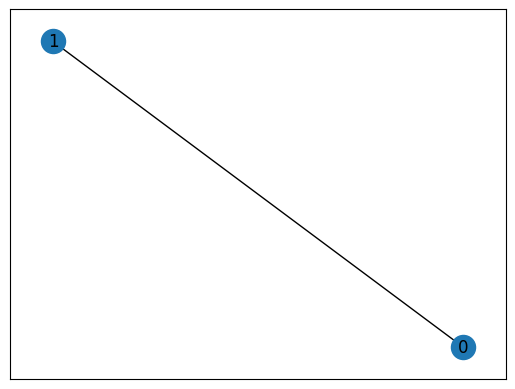

In [5]:
import networkx as nx
from networkx import Graph

def display_graph(num_vertices: int, edges_list: list[tuple[int]]) -> None:
    G = Graph()

    G.add_nodes_from(list(range(num_vertices)))
    G.add_edges_from(edges_list)

    nx.draw_networkx(G, pos=nx.spring_layout(G), with_labels=True)

display_graph(num_vertices=num_vertices, edges_list=edges_list)

## Manual Flip Oracle

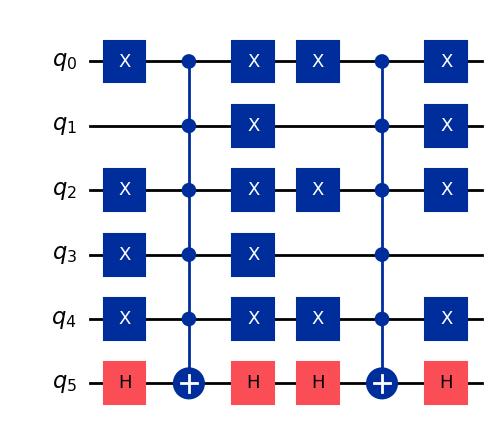

In [6]:
from qiskit import QuantumCircuit

def grover_oracle(num_qubits: int, marked_states: list[str]) -> QuantumCircuit:
    circuit = QuantumCircuit(num_qubits)

    for marked_state in marked_states:
        for i, bit in enumerate(reversed(marked_state)):
            if bit == '0':
                circuit.x(i)

        circuit.h(num_qubits - 1)
        circuit.mcx(list(range(num_qubits - 1)), num_qubits - 1)
        circuit.h(num_qubits - 1)

        for i, bit in enumerate(reversed(marked_state)):
            if bit == '0':
                circuit.x(i)

    return circuit

grover_oracle(num_qubits=num_qubits,
              marked_states=possible_solutions).draw("mpl")

### Test Oracle Circuit (Input State)

#### Positive Test Case

In [7]:
from qiskit.quantum_info import Statevector

test_vector_input = Statevector.from_label("101000")
test_vector_input.draw("latex")

<IPython.core.display.Latex object>

In [8]:
test_circuit = grover_oracle(num_qubits=num_qubits,
                             marked_states=possible_solutions)


test_vector_output = test_vector_input.evolve(test_circuit)
test_vector_output.draw("latex")

<IPython.core.display.Latex object>

#### Negative Test Case

In [9]:
from qiskit.quantum_info import Statevector

test_vector_input = Statevector.from_label("100000")
test_vector_input.draw("latex")

<IPython.core.display.Latex object>

In [10]:
test_circuit = grover_oracle(num_qubits=num_qubits,
                             marked_states=possible_solutions)


test_vector_output = test_vector_input.evolve(test_circuit)
test_vector_output.draw("latex")

<IPython.core.display.Latex object>

### Test Oracle Circuit (Super-Position States)

In [11]:
from qiskit.quantum_info import Statevector

test_vector_input = Statevector.from_label("000000")
test_vector_input.draw("latex")

<IPython.core.display.Latex object>

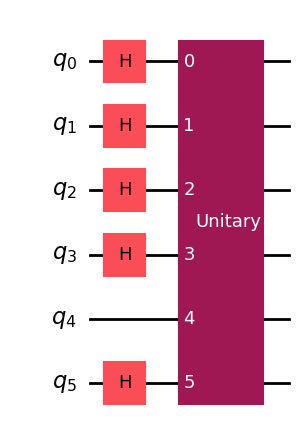

In [15]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator

test_circuit = QuantumCircuit(num_qubits)
test_circuit.h([0, 1, 2, 3, 5])

oracle_operator = Operator(grover_oracle(num_qubits=num_qubits,
                       marked_states=possible_solutions).to_gate())

test_circuit.append(oracle_operator, [0, 1, 2, 3, 4, 5])
test_circuit.draw("mpl")

In [11]:
test_vector_output = test_vector_input.evolve(test_circuit)
test_vector_output.draw("latex")

<IPython.core.display.Latex object>

In [12]:
import numpy as np

print(np.real(test_vector_output[int("101000", 2)]))
print(np.real(test_vector_output[int("100000", 2)]))

-0.1767766952966367
0.17677669529663667


## Ristricting State Space of the Two Node for Number of Colors

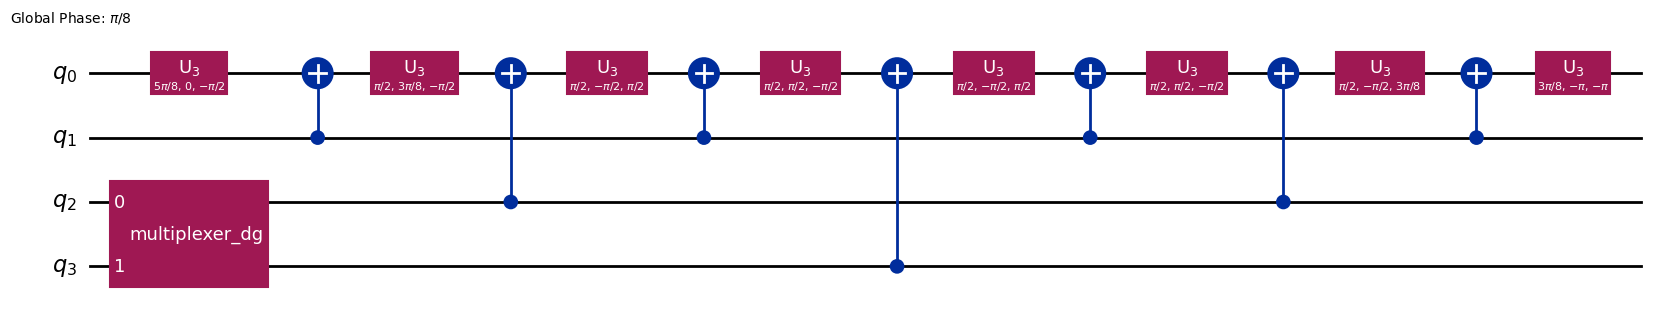

In [13]:
from itertools import product
import numpy as np
from qiskit.quantum_info import Statevector
from qiskit import QuantumCircuit, transpile
from qiskit_aer import AerSimulator
import textwrap

def circuit_initializer(num_qubits: int, restrict_states: list[str]) -> QuantumCircuit:
    circuit = QuantumCircuit(num_qubits)

    bin_seq = ["".join(seq) for seq in product("01", repeat=num_qubits)]
    bin_seq = list(map(lambda x: textwrap.wrap(x, 2), bin_seq))

    allowed_states = [state for state in bin_seq if not any(rs in state for rs in restrict_states)]
    allowed_states = list(map(lambda x: "".join(x), allowed_states))

    amplitude = len(allowed_states)
    bin_seq = list(map(lambda x: "".join(x), bin_seq))

    state_vec_amplitudes = [1 / np.sqrt(amplitude) if state in allowed_states else 0 for state in bin_seq]
    psi_0 = Statevector(state_vec_amplitudes)

    if psi_0.is_valid():
        circuit.initialize(psi_0)

    circuit = transpile(circuit)
    circuit.data = [inst for inst in circuit.data if inst.operation.name != "reset"]

    return circuit

circuit_initializer(num_qubits=4, restrict_states=["11", "10"]).draw("mpl")

### Test Circuit Initializer

In [14]:
from qiskit.quantum_info import Statevector

test_vector_input = Statevector.from_label("000000")
test_vector_input.draw("latex")

<IPython.core.display.Latex object>

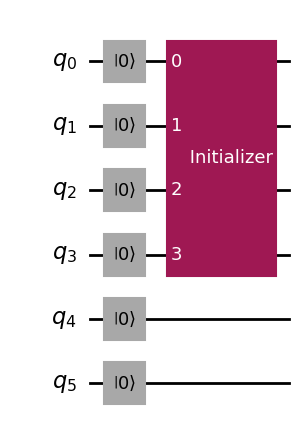

In [15]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator

test_circuit = QuantumCircuit(num_qubits)
test_circuit.reset(list(range(num_qubits)))

circuit_init = circuit_initializer(num_qubits=(num_vertices * 2),
                                   restrict_states=["11", "01"])

test_circuit.append(circuit_init.to_gate(label=" Initializer"), [0, 1, 2, 3])
test_circuit.draw("mpl")

In [16]:
test_vector_output = test_vector_input.evolve(test_circuit)
test_vector_output.draw("latex")

<IPython.core.display.Latex object>

#### Check if the state is Entangled

In [17]:
from qiskit.quantum_info import Statevector, DensityMatrix, partial_trace, entropy

def is_entangled(state: Statevector, epsilon: float=1e-10) -> bool:
    num_qubits = state.num_qubits
    density_matrix = DensityMatrix(state)

    for qubit in range(num_qubits):
        trace_out = [i for i in range(num_qubits) if i != qubit]
        reduced_dm = partial_trace(density_matrix, trace_out)

        subsystem_entropy = entropy(reduced_dm)

        if subsystem_entropy > epsilon:
            return True

    return False

In [18]:
is_entangled(state=test_vector_output)

False

#### Unitary Tests for Circuit Initializer

In [19]:
init_gate = Operator(circuit_init.to_gate())
init_gate.draw("latex")

<IPython.core.display.Latex object>

In [20]:
init_gate_dag = init_gate.transpose().conjugate()
init_gate_dag.draw("latex")

<IPython.core.display.Latex object>

In [21]:
print(init_gate.is_unitary())

True


In [22]:
Operator(init_gate @ init_gate_dag).draw("latex")

<IPython.core.display.Latex object>

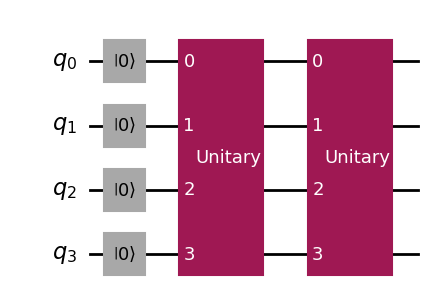

In [23]:
from qiskit import QuantumCircuit

test_circuit = QuantumCircuit(4)
test_circuit.reset(list(range(4)))

test_circuit.append(init_gate, [0, 1, 2, 3])
test_circuit.append(init_gate_dag, [0, 1, 2, 3])

test_circuit.draw("mpl")

In [24]:
from qiskit.quantum_info import Statevector

test_vector_input = Statevector.from_label("0000")
test_vector_input.draw("latex")

<IPython.core.display.Latex object>

In [25]:
test_vector_output = test_vector_input.evolve(test_circuit)
test_vector_output.draw("latex")

<IPython.core.display.Latex object>

Inference - Initializer Gate (or Circuit) is not Hermitian

### Test Circuit Initializer with H Gate to Output Qubit

In [26]:
from qiskit.quantum_info import Statevector

test_vector_input = Statevector.from_label("000000")
test_vector_input.draw("latex")

<IPython.core.display.Latex object>

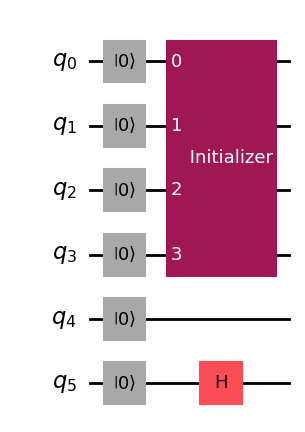

In [27]:
from qiskit import QuantumCircuit

test_circuit = QuantumCircuit(num_qubits)
test_circuit.reset(list(range(num_qubits)))

circuit_init = circuit_initializer(num_qubits=(num_vertices * 2),
                                   restrict_states=["11", "01"])

test_circuit.h(num_qubits - 1)
test_circuit.append(circuit_init.to_gate(label=" Initializer"), [0, 1, 2, 3])

test_circuit.draw("mpl")

In [28]:
test_vector_output = test_vector_input.evolve(test_circuit)
test_vector_output.draw("latex")

<IPython.core.display.Latex object>

#### Check if the state is Entangled

In [29]:
is_entangled(state=test_vector_output)

False

## Grover's Diffusion Operator

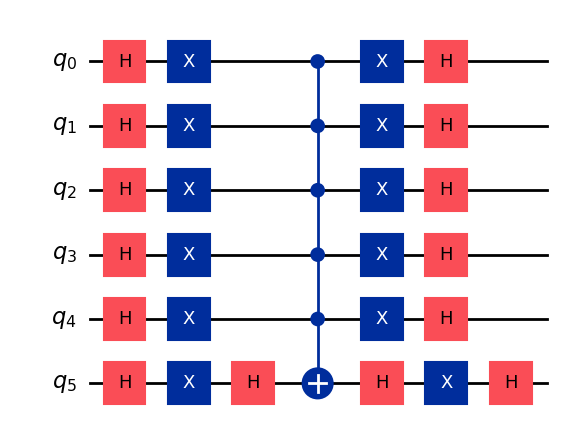

In [ ]:
from qiskit.circuit.library import GlobalPhaseGate
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
import numpy as np

def diffusion_operator(num_qubits: int) -> QuantumCircuit:
    circuit = QuantumCircuit(num_qubits)

    circuit.h(list(range(num_qubits)))
    circuit.x(list(range(num_qubits)))

    circuit.h(num_qubits - 1)
    circuit.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    circuit.h(num_qubits - 1)

    circuit.x(list(range(num_qubits)))
    circuit.h(list(range(num_qubits)))

    circuit.append(Operator(GlobalPhaseGate(phase=np.pi)))

    return circuit

diffusion_operator(num_qubits=((2 * num_vertices) + 1)).draw("mpl")

### Test Diffusion Operator on Random States Space

In [59]:
from qiskit.quantum_info import Statevector
import numpy as np

N = 3
size = 1

random_negative_idx = list(set(np.sort(np.random.randint(low=0, high=(2 ** N) - 1, size=size)).tolist()))
print(random_negative_idx)

test_vector_input = np.array(Statevector.from_label("+" * N))
test_vector_input[random_negative_idx] *= -1

test_vector_input = Statevector(test_vector_input)
test_vector_input.draw("latex")

[4]


<IPython.core.display.Latex object>

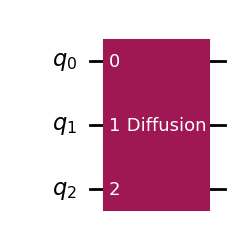

In [ ]:
from qiskit import QuantumCircuit
from qiskit.quantum_info import Operator

diffusion_op = Operator(diffusion_operator(num_qubits=N))

test_circuit = QuantumCircuit(N)
test_circuit.append(diffusion_op, list(range(N)))

test_circuit.draw("mpl")

In [33]:
test_vector_output = test_vector_input.evolve(test_circuit)
test_vector_output.draw("latex")

<IPython.core.display.Latex object>

#### Inference

If the number of Possible Solution is equal to half or more of the number of states space then the Diffusion operator will not Work.

##### Test Diffusion Operator Construction

In [68]:
from qiskit.quantum_info import Operator

test_vector_input = Statevector.from_label("+++")

test_outer = Operator((2 * np.outer(test_vector_input, test_vector_input)) - np.eye(8, 8))
test_outer.draw("latex")

<IPython.core.display.Latex object>

In [67]:
diffusion_op = Operator(diffusion_operator(num_qubits=N).to_gate())
diffusion_op.draw("latex")

<IPython.core.display.Latex object>

### Number of Iterations (If only One Solution)

In [34]:
import numpy as np

qubits = 3
N = 2 ** qubits

num_iter = np.floor((np.pi / 4) * np.sqrt(N))
print(num_iter)

2.0


### Number of Iterations (If more than One Solution)

In [35]:
import numpy as np

qubits = 3
N = 2 ** qubits
M = 3

num_iter = np.floor((np.pi / 4) * np.sqrt(N / M))
print(num_iter)

1.0


In [36]:
def get_num_iter(num_qubits: int, num_solutions: int = None) -> int:
    if num_solutions is None:
        num_solutions = 1

    return int(np.floor((np.pi / 4) * np.sqrt((2 ** num_qubits) / num_solutions)))

### Simulation Function

In [37]:
from qiskit import transpile, QuantumCircuit
from qiskit_aer.backends import AerSimulator
from qiskit.visualization import plot_histogram
from IPython.display import display

def simulate(circuit: QuantumCircuit, num_shots: int = 1024, display_circuit: bool = False) -> None:
    circuit.measure_all(add_bits=False)

    backend = AerSimulator()
    circuit = transpile(circuit, backend=backend)

    if display_circuit:
        display(circuit.draw("mpl"))

    counts = backend.run(circuit, shots=num_shots).result().get_counts()
    display(plot_histogram(counts, figsize=(15, 8)))

### Apply Grover Search on Problem (With all states space)

#### One Iteration

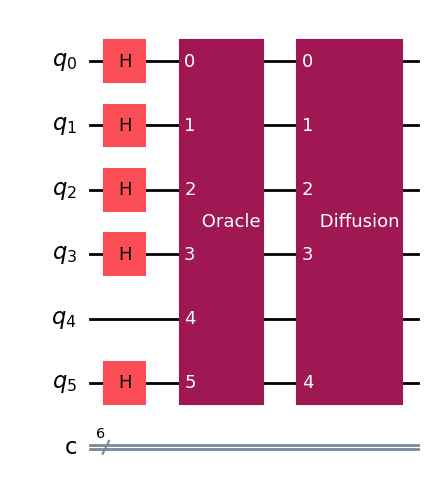

In [38]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

q_regs = QuantumRegister(num_qubits, name='q')
c_regs = ClassicalRegister(num_qubits, name='c')

circuit = QuantumCircuit(q_regs, c_regs)

circuit.h(q_regs[:2 * num_vertices])
circuit.h(q_regs[-1])

circuit.append(grover_oracle(
    num_qubits=num_qubits, marked_states=possible_solutions).to_gate(label=" Oracle"), q_regs)

circuit.append(diffusion_operator(num_qubits=(num_qubits - num_edges)).to_gate(label=" Diffusion"), [0, 1, 2, 3, 5])

circuit.draw("mpl")

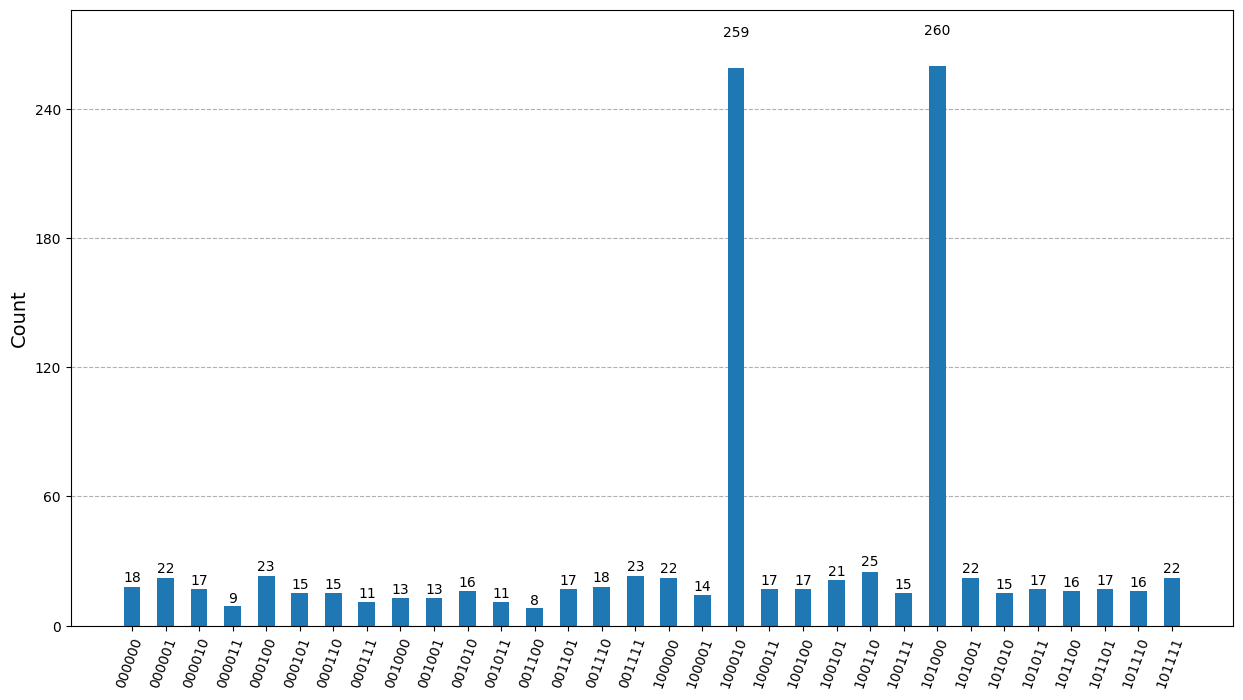

In [39]:
simulate(circuit=circuit)

#### Using Number of Iterations

In [40]:
num_iter = get_num_iter(num_qubits=(num_qubits - 1), num_solutions=len(possible_solutions))
print(num_iter)

3


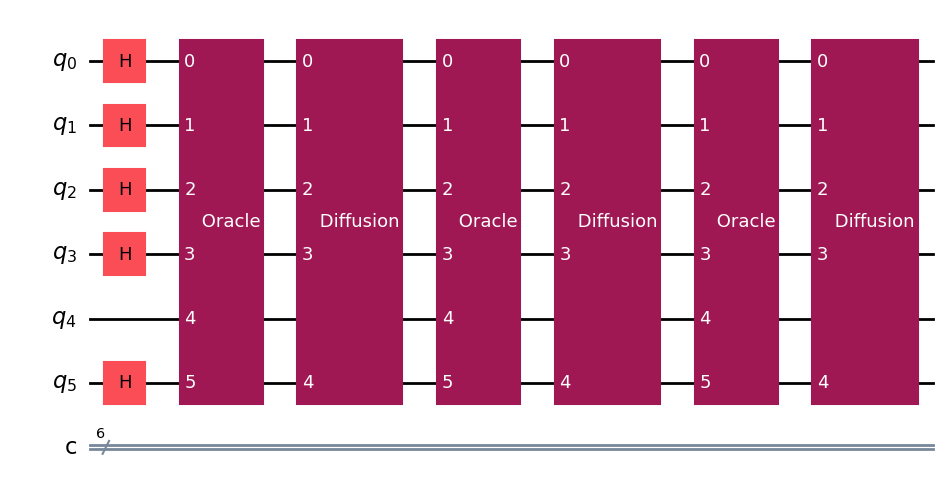

In [41]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

q_regs = QuantumRegister(num_qubits, name='q')
c_regs = ClassicalRegister(num_qubits, name='c')

circuit = QuantumCircuit(q_regs, c_regs)

circuit.h(q_regs[:2 * num_vertices])
circuit.h(q_regs[-1])

for _ in range(num_iter):
    circuit.append(grover_oracle(
        num_qubits=num_qubits, marked_states=possible_solutions).to_gate(label=" Oracle"), q_regs)

    circuit.append(diffusion_operator(num_qubits=(num_qubits - num_edges)).to_gate(label=" Diffusion"), [0, 1, 2, 3, 5])

circuit.draw("mpl")

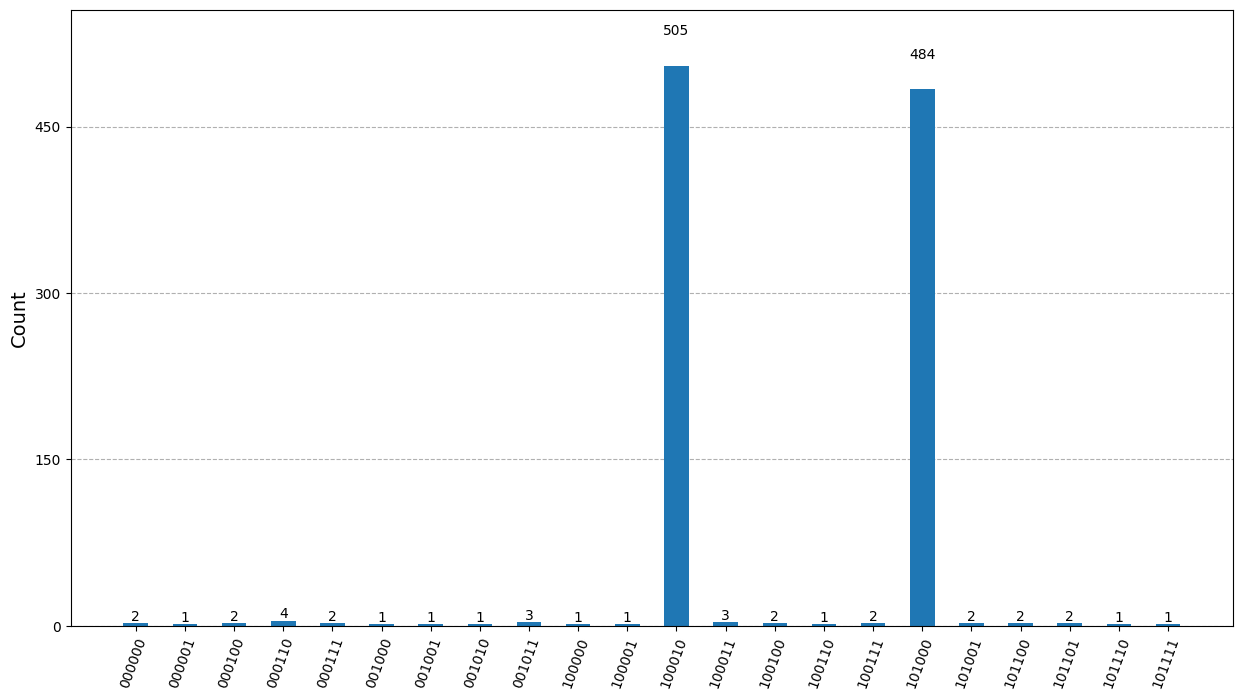

In [42]:
simulate(circuit=circuit)

### Apply Grover Search on Problem (With restricted states space)

#### One Iteration

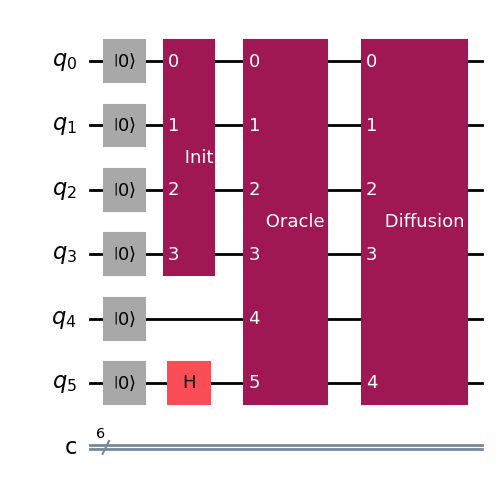

In [43]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister

q_regs = QuantumRegister(num_qubits, name='q')
c_regs = ClassicalRegister(num_qubits, name='c')

circuit = QuantumCircuit(q_regs, c_regs)
circuit.reset(q_regs)

circuit.append(circuit_initializer(
    num_qubits=(2 * num_vertices), restrict_states=["11", "10"]).to_gate(label=" Init"), q_regs[:(2 * num_vertices)])
circuit.h(q_regs[-1])

circuit.append(grover_oracle(
    num_qubits=num_qubits, marked_states=possible_solutions).to_gate(label=" Oracle"), q_regs)

circuit.append(diffusion_operator(num_qubits=(num_qubits - num_edges)).to_gate(label=" Diffusion"), [0, 1, 2, 3, 5])

circuit.draw("mpl")

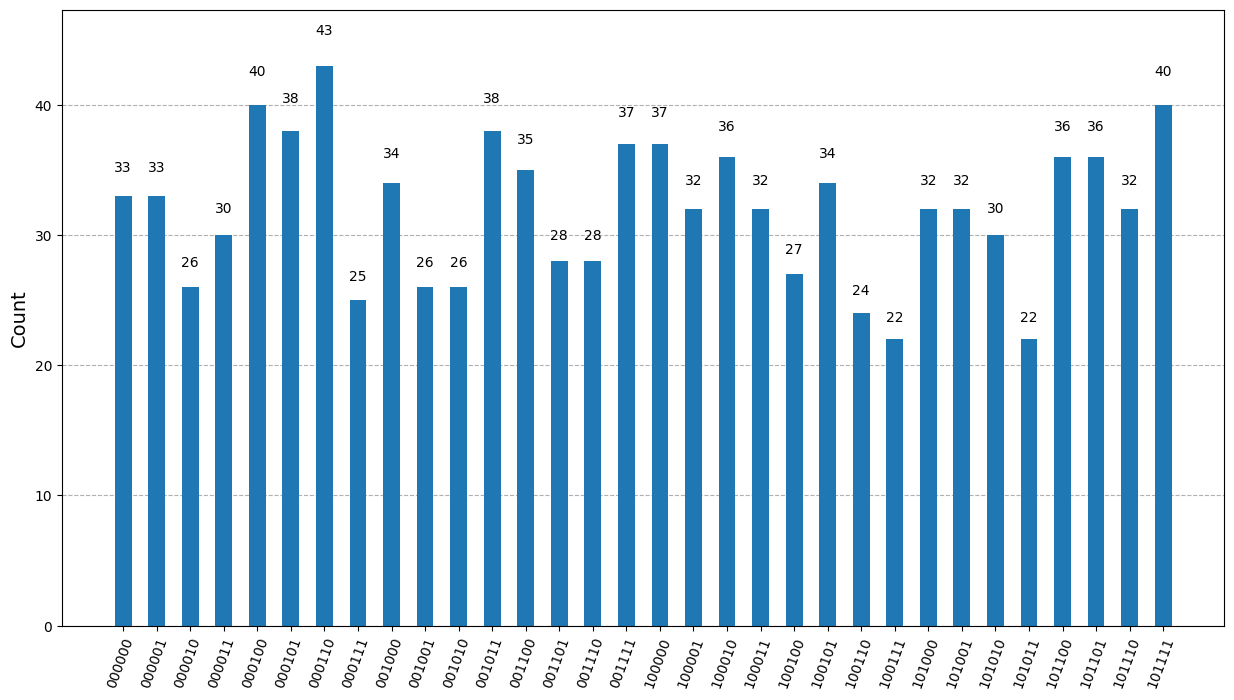

In [44]:
simulate(circuit=circuit)

#### Test Oracle on Ristricted State Space

In [45]:
from qiskit.quantum_info import Statevector

test_vector_input = Statevector.from_label("000000")
test_vector_input.draw("latex")

<IPython.core.display.Latex object>

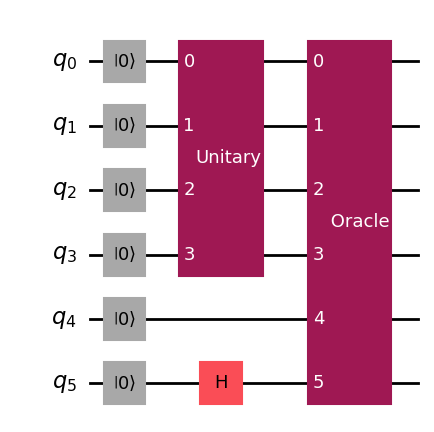

In [46]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Operator

q_regs = QuantumRegister(num_qubits, name='q')

test_circuit = QuantumCircuit(q_regs)
test_circuit.reset(q_regs)

circuit_init_gate = Operator(circuit_initializer(
    num_qubits=(2 * num_vertices), restrict_states=["11", "01"]).to_gate(label=" Init"))

circuit_init_gate_dag = circuit_init_gate.transpose().conjugate()

test_circuit.append(circuit_init_gate, q_regs[:(2 * num_vertices)])
test_circuit.h(q_regs[-1])

test_circuit.append(grover_oracle(
    num_qubits=num_qubits, marked_states=possible_solutions).to_gate(label=" Oracle"), q_regs)

test_circuit.draw("mpl")

In [47]:
test_vector_output = test_vector_input.evolve(test_circuit)

print(is_entangled(test_vector_output))
test_vector_output.draw("latex")

True


<IPython.core.display.Latex object>

#### Custom Diffusion Operator

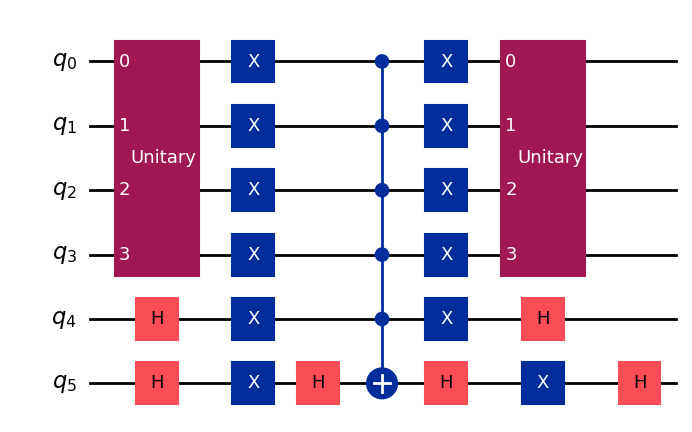

In [85]:
from qiskit.circuit.library import GlobalPhaseGate
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
import numpy as np

def custom_diffusion_operator(num_qubits: int, init_qubits: list[int], circuit_init_gate: Operator) -> QuantumCircuit:
    circuit = QuantumCircuit(num_qubits)

    circuit_init_gate_dag = circuit_init_gate.transpose().conjugate()

    circuit.append(circuit_init_gate, init_qubits)
    circuit.h(list(range(num_qubits))[len(init_qubits):])
    circuit.x(list(range(num_qubits)))

    circuit.h(num_qubits - 1)
    circuit.mcx(list(range(num_qubits - 1)), num_qubits - 1)
    circuit.h(num_qubits - 1)

    circuit.x(list(range(num_qubits)))
    circuit.append(circuit_init_gate_dag, init_qubits)
    circuit.h(list(range(num_qubits))[len(init_qubits):])

    circuit.append(Operator(GlobalPhaseGate(phase=np.pi)))

    return circuit

circuit_init_gate = Operator(circuit_initializer(
    num_qubits=(2 * num_vertices), restrict_states=["11", "01"]).to_gate(label=" Init"))

custom_diffusion_operator(num_qubits=num_qubits, init_qubits=[0, 1, 2, 3], circuit_init_gate=circuit_init_gate).draw("mpl")

##### Test Custom Diffusion Operator Construction

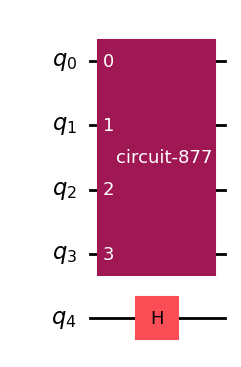

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [ ]:
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
from IPython.display import display

test_circuit = QuantumCircuit(5)

circuit_init = circuit_initializer(
    num_qubits=4, restrict_states=["11", "01"]).to_gate()

test_circuit.append(circuit_init, [0, 1, 2, 3])
test_circuit.h(4)

display(test_circuit.draw("mpl"))

test_vector_input = Statevector.from_instruction(test_circuit)

display(test_vector_input.draw("latex"))

test_outer = Operator((2 * np.outer(test_vector_input, test_vector_input)) - np.eye(32, 32))
test_outer.draw("latex")

In [87]:
circuit_init_gate = Operator(circuit_initializer(
    num_qubits=4, restrict_states=["11", "01"]).to_gate(label=" Init"))

diffusion_op = Operator(custom_diffusion_operator(
    num_qubits=5, init_qubits=[0, 1, 2, 3], circuit_init_gate=circuit_init_gate).to_gate())

diffusion_op.draw("latex")

<IPython.core.display.Latex object>

#### Test with Custom Diffusion Operator (One Iteration)

In [120]:
from qiskit.quantum_info import Statevector

test_vector_input = Statevector.from_label("000000")
test_vector_input.draw("latex")

<IPython.core.display.Latex object>

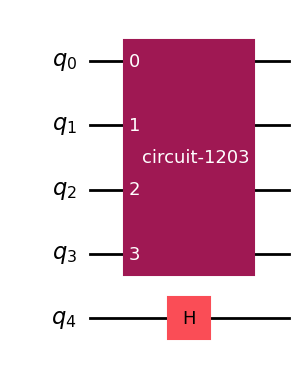

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

In [121]:
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit
from IPython.display import display

test_circuit = QuantumCircuit(5)

circuit_init = circuit_initializer(
    num_qubits=4, restrict_states=["11", "01"]).to_gate()

test_circuit.append(circuit_init, [0, 1, 2, 3])
test_circuit.h(4)

display(test_circuit.draw("mpl"))

test_vector_input_dop = Statevector.from_instruction(test_circuit)

display(test_vector_input_dop.draw("latex"))

test_outer = Operator((2 * np.outer(test_vector_input_dop, test_vector_input_dop)) - np.eye(32, 32))
test_outer.draw("latex")

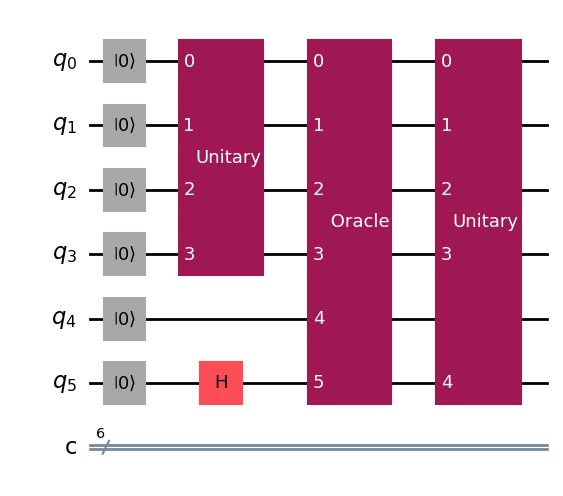

In [122]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Operator

q_regs = QuantumRegister(num_qubits, name='q')
c_regs = ClassicalRegister(num_qubits, name='c')

test_circuit = QuantumCircuit(q_regs, c_regs)
test_circuit.reset(q_regs)

circuit_init_gate = Operator(circuit_initializer(
    num_qubits=(2 * num_vertices), restrict_states=["11", "01"]).to_gate(label=" Init"))

circuit_init_gate_dag = circuit_init_gate.transpose().conjugate()

test_circuit.append(circuit_init_gate, q_regs[:(2 * num_vertices)])
test_circuit.h(q_regs[-1])

test_circuit.append(grover_oracle(
    num_qubits=num_qubits, marked_states=possible_solutions).to_gate(label=" Oracle"), q_regs)

# test_circuit.append(custom_diffusion_operator(num_qubits=(num_qubits - num_edges), init_qubits=[0, 1, 2, 3],
#                                        circuit_init_gate=circuit_init_gate).to_gate(label=" Diffusion"), [0, 1, 2, 3, 5])

test_circuit.append(test_outer, [0, 1, 2, 3, 5])

test_circuit.draw("mpl")

In [132]:
test_vector_output = test_vector_input.evolve(test_circuit)

print(is_entangled(test_vector_output))
test_vector_output.draw("latex")

True


<IPython.core.display.Latex object>

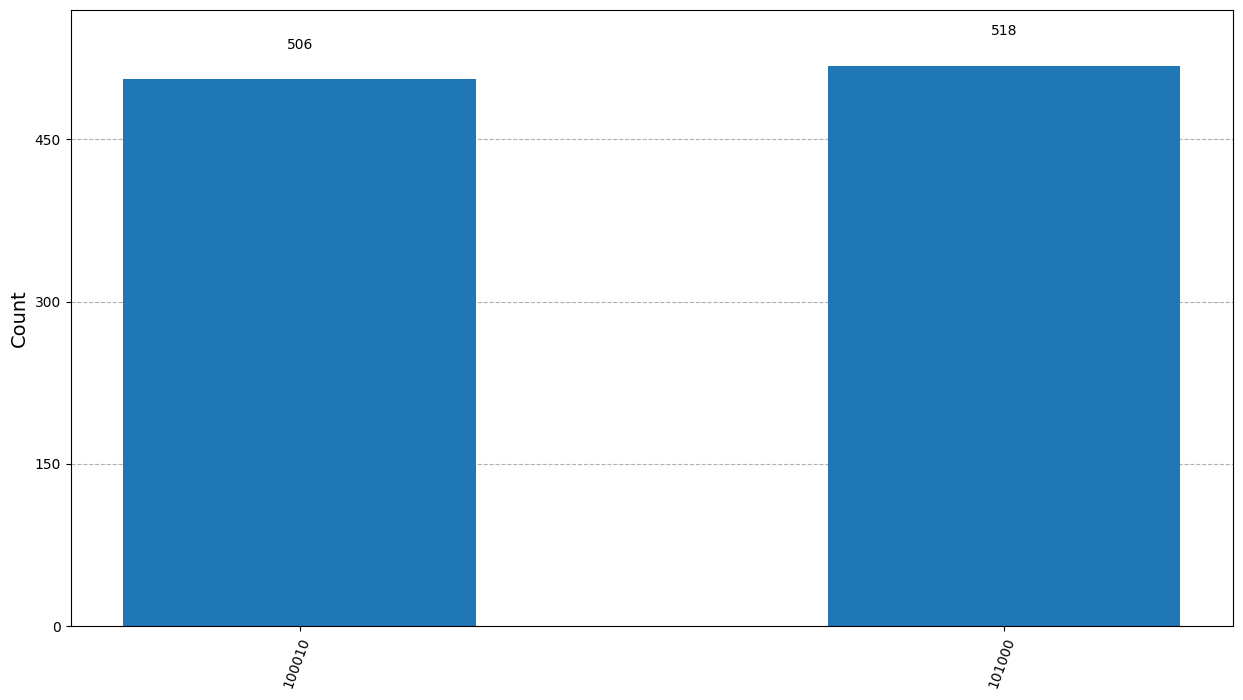

In [118]:
simulate(circuit=test_circuit)

#### Test with Custom Diffusion Operator (Number of Iteration)

In [53]:
import numpy as np

qubits = 3
N = 8
M = 2

num_iter = np.floor((np.pi / 4) * np.sqrt(N / M))
print(num_iter)

1.0


In [54]:
from qiskit.quantum_info import Statevector

test_vector_input = Statevector.from_label("000000")
test_vector_input.draw("latex")

<IPython.core.display.Latex object>

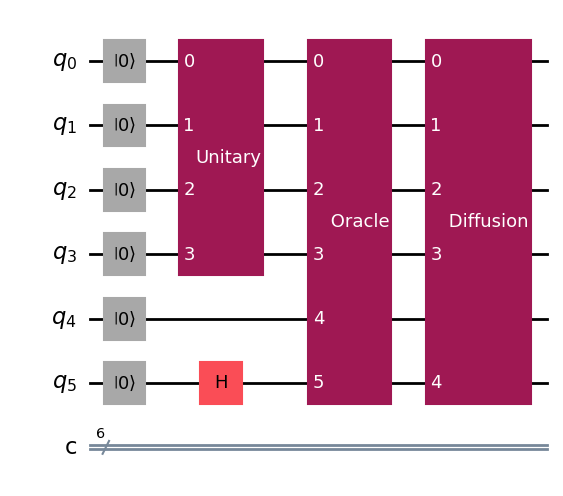

In [55]:
from qiskit import QuantumCircuit, QuantumRegister
from qiskit.quantum_info import Operator

q_regs = QuantumRegister(num_qubits, name='q')
c_regs = ClassicalRegister(num_qubits, name='c')

test_circuit = QuantumCircuit(q_regs, c_regs)
test_circuit.reset(q_regs)

circuit_init_gate = Operator(circuit_initializer(
    num_qubits=(2 * num_vertices), restrict_states=["11", "01"]).to_gate(label=" Init"))

circuit_init_gate_dag = circuit_init_gate.transpose().conjugate()

test_circuit.append(circuit_init_gate, q_regs[:(2 * num_vertices)])
test_circuit.h(q_regs[-1])

test_circuit.append(grover_oracle(
    num_qubits=num_qubits, marked_states=possible_solutions).to_gate(label=" Oracle"), q_regs)

test_circuit.append(custom_diffusion_operator(num_qubits=(num_qubits - num_edges), init_qubits=[0, 1, 2, 3],
                                       circuit_init_gate=circuit_init_gate).to_gate(label=" Diffusion"), [0, 1, 2, 3, 5])

test_circuit.draw("mpl")

In [56]:
test_vector_output = test_vector_input.evolve(test_circuit)

print(is_entangled(test_vector_output))
test_vector_output.draw("latex")

True


<IPython.core.display.Latex object>

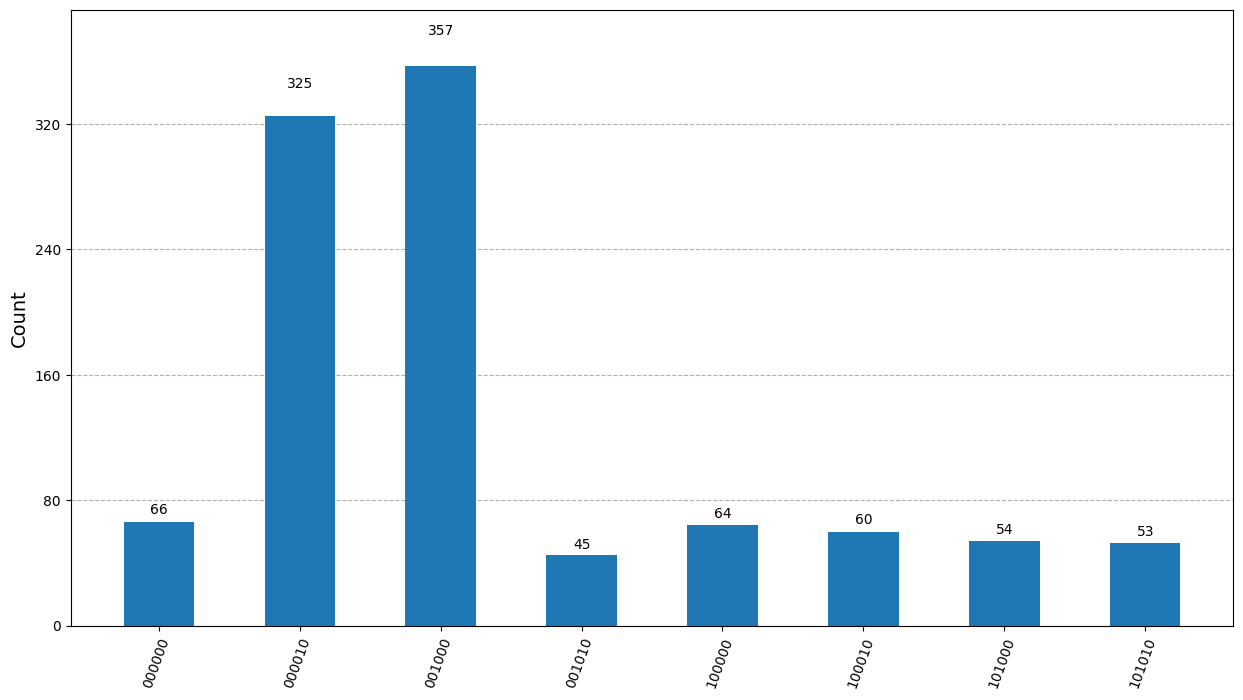

In [57]:
simulate(circuit=test_circuit)